# Setup the environemnt and install all packages 

________________
## Setup 🔧

**1. Clone the repository**

```bash
git clone https://github.com/Cerlog/02807-project
```

**2. Create conda environment** 
```bash
conda create -n 02807-project python=3.11 -y
```

**3. Activate the environment**
```bash 
conda activate 02807-project
```

**4. Change the directories** 
```bash
cd 02807-project
```
**5. Install the requirements**

```bash
pip install -r requirements.txt
```
_______________

# Integrating Graph Clustering and Association Rule Mining on the Yelp Dataset for Detection of Global and Local Patterns

In [65]:
import os
import json
import nltk
import random
import community.community_louvain as community_louvain  
from networkx.algorithms.community import modularity
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sys
import importlib
import pickle

# Add the src/ folder to Python path

from pathlib import Path
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from collections import defaultdict
from functions import *
PROJECT_ROOT = Path().resolve()
SRC_DIR = PROJECT_ROOT / "src"
sys.path.append(str(SRC_DIR))
sys.path.insert(0, str(SRC_DIR))

import data as d
import apriori as ap
import preprocessing as pr

importlib.reload(ap)
SEED = 1337

os.environ["PYTHONHASHSEED"] = str(SEED)  
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)  




# Define base directory
DATA_DIR_RAW = Path("data/raw")
DATA_DIR_PROC = Path("data/processed")

# Define file paths
USERS   = DATA_DIR_RAW / "user.json"
REVIEWS = DATA_DIR_RAW / "review.json"
REVIEWS_CLEAN = DATA_DIR_RAW / "review_clean.ndjson"
BIZ     = DATA_DIR_RAW / "business.json"

# categories of restaurants
FOOD = DATA_DIR_RAW / "Food.txt"
RESTAURANTS = DATA_DIR_RAW / "restaurants.txt"


DATASET_URLS = [
    "https://drive.google.com/file/d/163KgvKNYPTV5_fArvlBiNkqb6rCDkk-Z/view?usp=drive_link",
    "https://drive.google.com/file/d/1O5kEcRxvnO1da74y9y5AE92h_QlOfjmL/view?usp=drive_link",
    "https://drive.google.com/file/d/1ox-qrD1sSKalbu25FIbu-kYGMvkn3Y3k/view?usp=drive_link", 
    "https://drive.google.com/file/d/1cJx0UUVxwsKL8DHpwrGoqBSlRA2v4I2f/view?usp=drive_link",
    "https://drive.google.com/file/d/10wpi7RzZTpt93_7uRZcshvA5X3ek3_Kc/view?usp=drive_link"
]

# https://www.kaggle.com/datasets/yaldayazdanpanah/yelpcategorytitles/data
#https://business.yelp.com/data/resources/open-dataset/

# Set random seeds for reproducibility
SEED = 1337
os.environ["PYTHONHASHSEED"] = str(SEED)  
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)  

# Get the dataset 

In [13]:
d.download_dataset(DATASET_URLS, DATA_DIR_RAW)

2025-11-23 14:23:16.922 | INFO     | data:download_dataset:35 - Downloading from https://drive.google.com/file/d/1cJx0UUVxwsKL8DHpwrGoqBSlRA2v4I2f/view?usp=drive_link...
Downloading...
From: https://drive.google.com/uc?id=1cJx0UUVxwsKL8DHpwrGoqBSlRA2v4I2f
To: /home/pnylander/DTU/4thSemester/02807/02807-project/Food.txt
100%|██████████| 791/791 [00:00<00:00, 3.10MB/s]
2025-11-23 14:23:19.025 | SUCCESS  | data:download_dataset:42 - ✅ Downloaded to 'data/raw/Food.txt'
2025-11-23 14:23:19.026 | WARNING  | data:clean_review_json:10 - Can't find 'review.json' to clean.
2025-11-23 14:23:19.026 | INFO     | data:download_dataset:35 - Downloading from https://drive.google.com/file/d/10wpi7RzZTpt93_7uRZcshvA5X3ek3_Kc/view?usp=drive_link...
Downloading...
From: https://drive.google.com/uc?id=10wpi7RzZTpt93_7uRZcshvA5X3ek3_Kc
To: /home/pnylander/DTU/4thSemester/02807/02807-project/restaurants.txt
100%|██████████| 1.59k/1.59k [00:00<00:00, 3.60MB/s]
2025-11-23 14:23:21.454 | SUCCESS  | data:downloa

# Processing the dataset 

Importing of the needed parts of the Yelp dataset. 

In [ ]:
# import the data
user = pd.read_json(USERS, lines=True, dtype={"user_id": str}, engine="pyarrow")
review = pd.read_json(REVIEWS_CLEAN, lines=True, engine="pyarrow")
business = pd.read_json(BIZ, lines=True, dtype_backend="pyarrow")
#print("Length of business before NAN removal:", len(business))
# drop all the nans within categories
business = business.dropna(subset=["categories"])
#print("Length of business after NAN removal:", len(business))

business = business.reset_index(drop=True) # reset the index after dropping nans 

Length of business before NAN removal: 150346
Length of business after NAN removal: 150243


We are intersted only in the reviews of businesses which are food and restaurants related, so therefore we filter the business dataset to only contain those entries.

In [8]:
is_food_rest = business["categories"].str.contains(r"\b(?:Restaurants|Food)\b", case=False, na=False)
business = business.loc[is_food_rest].copy().reset_index(drop=True)

In [ ]:
# save the business for later use 
#business.to_json(DATA_DIR_PROC / "business_food_restaurants.json", orient="records", lines=True)

Now we have only the food and restaurant related businesses in the business dataframe. The problem is however, that many of the reviews are for businesses contain multiple categories, see the examples bellow. Therefore we need to reduce the categories to only one per business. From the the kaggle dataset, we have all the categories within **Restaurants** and **Foods** that are included in the yelp dataset, from which we will build a dictionary of the categories in the entire dataset in order to reduce the multiple categories into only one overall category per business. 


In [11]:
# number of unique categories 
len(business["categories"].unique())

business["categories"].head()

0    Restaurants, Food, Bubble Tea, Coffee & Tea, B...
1                            Brewpubs, Breweries, Food
2    Burgers, Fast Food, Sandwiches, Food, Ice Crea...
3    Pubs, Restaurants, Italian, Bars, American (Tr...
4    Ice Cream & Frozen Yogurt, Fast Food, Burgers,...
Name: categories, dtype: string[pyarrow]

In [16]:
# creating the categories in order list
pr.CATEGORIES_IN_ORDER = pr.get_categories(RESTAURANTS, FOOD)

Creating new column based on the reduced categories.

In [17]:
random.seed(SEED)
np.random.seed(SEED)
business["simple_category"] = business["categories"].apply(pr.simplify_random)

In [ ]:
# save the dataframe for later use
business.to_json(DATA_DIR_PROC / "business_food_restaurants_simple_categories.json", orient="records", lines=True)

In order to see how this affects the distribution of the dataset, i.e. of choosing Bubble Tea instead of Coffee & Tea, we run a simple experiment to see see if the categories are affected by this simplification. 

In [19]:
pr.simple_experiment(business, n_runs=100, random_seed=SEED)

Ran 100 random trials.
Average change in category (mean std):   0.0001
Average category share (mean of means):        0.0049
Average coefficient of variation (mean cv):    0.0208

Most unstable categories (by CV):
                            mean       std        cv
categories                                          
Food Delivery Services  0.005724  0.000234  0.040806
Southern                0.005321  0.000215  0.040430
Greek                   0.005103  0.000206  0.040344
Mediterranean           0.007037  0.000243  0.034566
Asian Fusion            0.008226  0.000269  0.032652
Donuts                  0.007968  0.000234  0.029401
Salad                   0.012550  0.000368  0.029359
Juice Bars & Smoothies  0.009181  0.000269  0.029253
Steakhouses             0.009447  0.000273  0.028868
Food Trucks             0.008098  0.000232  0.028639


From the 100 trials (plan was to do more, but it took much longer time than expected), we can see that when choosen at random, the distribution odes not change significantly, therefore we can justify the simplification of the categories. 

In [20]:
business["categories"].head(10)

0    Restaurants, Food, Bubble Tea, Coffee & Tea, B...
1                            Brewpubs, Breweries, Food
2    Burgers, Fast Food, Sandwiches, Food, Ice Crea...
3    Pubs, Restaurants, Italian, Bars, American (Tr...
4    Ice Cream & Frozen Yogurt, Fast Food, Burgers,...
5           Vietnamese, Food, Restaurants, Food Trucks
6    American (Traditional), Restaurants, Diners, B...
7          Food, Delis, Italian, Bakeries, Restaurants
8                    Sushi Bars, Restaurants, Japanese
9                                  Korean, Restaurants
Name: categories, dtype: string[pyarrow]

In [22]:
print(f"Number of unique simplified categories: {len(business['simple_category'].unique())}")

Number of unique simplified categories: 201


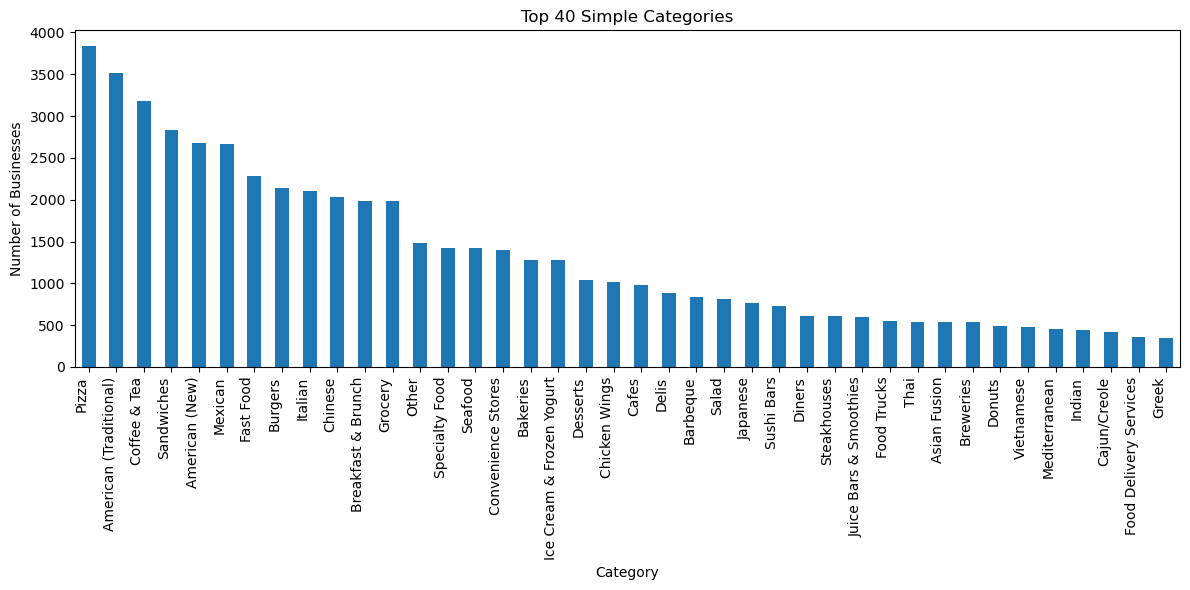

In [27]:
top_k_simple_categories = 40
category_counts = business["simple_category"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,6))
category_counts.head(top_k_simple_categories).plot(kind='bar')
plt.title(f"Top {top_k_simple_categories} Simple Categories")
plt.xlabel("Category")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=90, ha="right")  
plt.tight_layout()                  
plt.savefig("figures/simple_categories_distribution.svg",dpi=300)
plt.show()


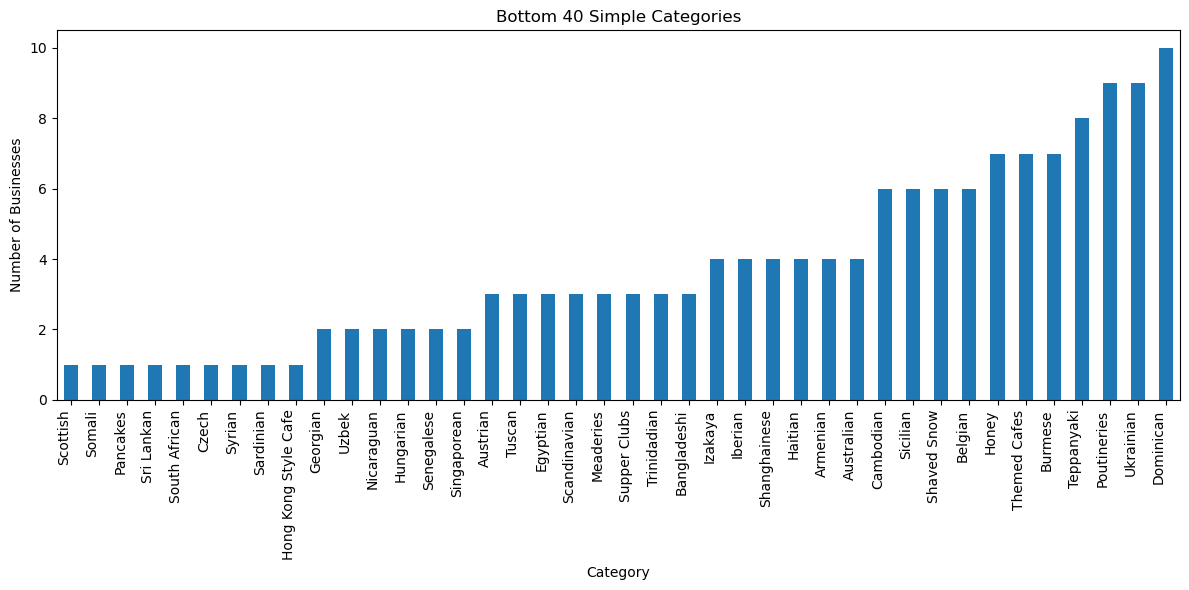

In [28]:
bottom_k_simple_categories = 40
category_counts = business["simple_category"].value_counts().sort_values(ascending=True)
plt.figure(figsize=(12,6))
category_counts.head(bottom_k_simple_categories).plot(kind='bar')
plt.title(f"Bottom {bottom_k_simple_categories} Simple Categories")
plt.xlabel("Category")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=90, ha="right")  
plt.tight_layout()                  
plt.savefig("figures/simple_categories_least_common.svg", dpi=300)
plt.show()

In [30]:
proportion_of_top_20 = business["simple_category"].value_counts()
print("Share of the first top 20 companies:", proportion_of_top_20.head(20).sum()/proportion_of_top_20.sum())


Share of the first top 20 companies: 0.6431843506252322


Now, that we have the reduced categories, we need to process the data into a form, that can be used by the apriori algorithm.

In [31]:
# Load and prepare business mapping
#df.to_parquet(DATA_DIR_PROC / "business_processed.parquet", index=False)
biz_proc = pd.read_parquet(DATA_DIR_PROC / "business_processed.parquet")[["business_id", "simple_category"]]

The Apriori algorithm is most efficient, if we assign every category an unique integer ID and threffore we need to create a mapping from category to ID and vice versa.

In [37]:
# create a list of alphabetically sorted unique categories
cats = sorted(biz_proc["simple_category"].drop_duplicates().to_list())
#print(f"Unique simplified categories: {cats}")
# create dictionary mapping from category to ID
cat_to_id = {cat: idx for idx, cat in enumerate(cats)}
#print(f"Category to ID mapping: {cat_to_id}")
# create reverse mapping from ID to category
id2cat_map = {idx: cat for cat, idx in cat_to_id.items()}
#print(f"ID to Category mapping: {id2cat_map}")

# Save category vocabulary
pd.DataFrame({"cat_id": range(len(cats)), "simple_category": cats}).to_parquet(
    DATA_DIR_PROC / "cat_vocab.parquet", index=False
)

Now, we create a lookup table for the businesses to their assigned category IDs.

In [41]:
# Create business mapping
biz_map = (biz_proc.assign(cat_id=lambda d: d["simple_category"].map(cat_to_id))[["business_id", "cat_id"]].drop_duplicates("business_id").set_index("business_id"))
biz_map.head()
print(f"Created mappings for {len(cats)} categories")
biz_map

Created mappings for 201 categories


,cat_id
business_id,
MTSW4McQd7CbVtyjqoe9mw,43
mWMc6_wTdE0EUBKIGXDVfA,21
CF33F8-E6oudUQ46HnavjQ,67
k0hlBqXX-Bt0vf1op7Jr1w,82
bBDDEgkFA1Otx9Lfe7BZUQ,67
...,...
cM6V90ExQD6KMSU3rRB5ZA,29
1jx1sfgjgVg0nM6n3p0xWA,44
WnT9NIzQgLlILjPT0kEcsQ,121


Now we create a sets of liked and hated category IDs per user. Where we for each user build a set of categories they liked and disliked based on the star ratings in their reviews.

In [46]:
liked_ids = defaultdict(set)
hated_ids = defaultdict(set)

usecols = ["user_id", "business_id", "stars"]

Because of the size of the review dataset, we process the reviews in chunks of 500.000 entries at a time to avoid memory issues. 

In this code, we crate two baskets for each user, one with the categories they liked (gave review stars >= 4) and one with the categories they hated (gave review stars < 3). 

In [48]:
for chunk in pd.read_json(REVIEWS_CLEAN, lines=True, dtype_backend="pyarrow", chunksize=500_000):
    r = (chunk[usecols]
         .dropna(subset=["user_id", "business_id", "stars"])
         .copy())
    
    # Convert to string
    r["user_id"] = r["user_id"].astype("string[pyarrow]")
    r["business_id"] = r["business_id"].astype("string[pyarrow]")
    
    
    # Split by stars
    high = r[r["stars"] >= 4.0]
    low = r[r["stars"] < 3.0]  # 
    
    # Join with business mapping and accumulate
    if len(high):
        high = high.join(biz_map, on="business_id", how="inner")
        for uid, cats in high.groupby("user_id")["cat_id"]:
            liked_ids[str(uid)].update(cats.unique())
    
    if len(low):
        low = low.join(biz_map, on="business_id", how="inner")
        for uid, cats in low.groupby("user_id")["cat_id"]:
            hated_ids[str(uid)].update(cats.unique())

Now, we created the dataframes and keep the baskets that have at least 2 items. 

In [49]:
# Create basket dataframes
liked_baskets_ids = pd.DataFrame({
    "user_id": list(liked_ids.keys()),
    "items": [sorted(list(s)) for s in liked_ids.values()]
})

hated_baskets_ids = pd.DataFrame({
    "user_id": list(hated_ids.keys()),
    "items": [sorted(list(s)) for s in hated_ids.values()]
})

# 
liked_baskets_ids = liked_baskets_ids[liked_baskets_ids["items"].map(len) >= 2]
hated_baskets_ids = hated_baskets_ids[hated_baskets_ids["items"].map(len) >= 2]

# Save all basket variants
liked_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_liked_ids.parquet", index=False)
hated_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_hated_ids.parquet", index=False)

print(f"Liked baskets: {len(liked_baskets_ids)} users (with 2+ items)")
print(f"Hated baskets: {len(hated_baskets_ids)} users (with 2+ items)")

Liked baskets: 326145 users (with 2+ items)
Hated baskets: 140272 users (with 2+ items)


# Apriori on the entire dataset 

In [ ]:
CAT_VOCAB     = DATA_DIR_PROC / "cat_vocab.parquet"
BASKETS_LIKED = DATA_DIR_PROC / "baskets_liked_ids.parquet"
BASKETS_HATED = DATA_DIR_PROC / "baskets_hated_ids.parquet"
OUT_DIR       = DATA_DIR_PROC / "apriori_results"

In [54]:
# Load category mapping 
id2cat_df  = pd.read_parquet(CAT_VOCAB)
id2cat_map = id2cat_df.set_index("cat_id")["simple_category"].to_dict()

In [66]:
MIN_SUPPORT = 0.02
MIN_CONF    = 0.4
    
df_rules_liked = ap.run_apriori("liked", BASKETS_LIKED, MIN_SUPPORT, MIN_CONF, OUT_DIR, id2cat_map)
df_rules_hated = ap.run_apriori("hated", BASKETS_HATED, MIN_SUPPORT, MIN_CONF, OUT_DIR, id2cat_map)

print("\n" + "="*50)
print(f"Rules liked: {len(df_rules_liked)}")
print(f"Rules hated: {len(df_rules_hated)}")
print("="*50)

Running Apriori for liked
Generated 148 liked rules
Saved 148 liked rules
  → data/processed/apriori_results/rules_liked.parquet
  → data/processed/apriori_results/rules_liked_human.csv
Running Apriori for hated
Generated 12 hated rules
Saved 12 hated rules
  → data/processed/apriori_results/rules_hated.parquet
  → data/processed/apriori_results/rules_hated_human.csv

Rules liked: 148
Rules hated: 12


In [67]:
df_rules_liked

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
144,"(3, 4, 19)","(121,)",0.020687,0.577456,3.132330,"(American (New), American (Traditional), Break...","(Mexican,)"
145,"(3, 4, 121)","(19,)",0.020687,0.616108,3.121892,"(American (New), American (Traditional), Mexican)","(Breakfast & Brunch,)"
46,"(104, 121)","(138,)",0.020184,0.482200,2.973759,"(Italian, Mexican)","(Pizza,)"
14,"(121, 151)","(138,)",0.021579,0.475991,2.935464,"(Mexican, Sandwiches)","(Pizza,)"
146,"(3, 19, 121)","(4,)",0.020687,0.704795,2.889316,"(American (New), Breakfast & Brunch, Mexican)","(American (Traditional),)"
...,...,...,...,...,...,...,...
10,"(172,)","(4,)",0.030143,0.406055,1.664628,"(Steakhouses,)","(American (Traditional),)"
9,"(170,)","(4,)",0.027742,0.401705,1.646794,"(Specialty Food,)","(American (Traditional),)"
4,"(170,)","(3,)",0.028877,0.418132,1.640008,"(Specialty Food,)","(American (New),)"
0,"(11,)","(3,)",0.028665,0.416437,1.633359,"(Bakeries,)","(American (New),)"


In [68]:
df_rules_hated

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
3,"(4, 104)","(3,)",0.022221,0.475442,2.194441,"(American (Traditional), Italian)","(American (New),)"
8,"(3, 25)","(4,)",0.021344,0.562888,2.100825,"(American (New), Burgers)","(American (Traditional),)"
7,"(4, 19)","(3,)",0.023205,0.450706,2.080269,"(American (Traditional), Breakfast & Brunch)","(American (New),)"
11,"(4, 151)","(3,)",0.021558,0.441653,2.038485,"(American (Traditional), Sandwiches)","(American (New),)"
5,"(4, 121)","(3,)",0.025087,0.438778,2.025214,"(American (Traditional), Mexican)","(American (New),)"
1,"(4, 138)","(3,)",0.022706,0.432392,1.995739,"(American (Traditional), Pizza)","(American (New),)"
10,"(3, 151)","(4,)",0.021558,0.533051,1.989468,"(American (New), Sandwiches)","(American (Traditional),)"
9,"(4, 25)","(3,)",0.021344,0.430234,1.985779,"(American (Traditional), Burgers)","(American (New),)"
6,"(3, 19)","(4,)",0.023205,0.521551,1.946547,"(American (New), Breakfast & Brunch)","(American (Traditional),)"
0,"(3, 138)","(4,)",0.022706,0.520936,1.944249,"(American (New), Pizza)","(American (Traditional),)"


# Grap Network 

In [9]:
with open(USERS, 'r') as f:
    user_counts = Counter(json.loads(line)['user_id'] for line in f)


In [10]:
# number of unique users
num_unique_users = len(user_counts)
print(f'Number of unique users: {num_unique_users}')

Number of unique users: 1987897


In [11]:
# create graph
G = nx.Graph()
G.add_nodes_from(user_counts.keys())
with open(USERS, 'r') as f:
    for line in f:
        user = json.loads(line)
        user_id = user['user_id']
        friends = user['friends'].split(', ') if user['friends'] != 'None' else []
        for friend in friends:
            if friend in user_counts:
                G.add_edge(user_id, friend)

In [12]:
degrees = [G.degree(node) for node in G.nodes()]
sorted(degrees)
no_friends = sum(count == 0 for count in degrees)
print(f'Number of users with no friends in the network: {no_friends}')

Number of users with no friends in the network: 1081718


In [13]:
number_of_nodes_full_network = G.number_of_nodes()
number_of_edges_full_network = G.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 1987897
Number of edges in the graph: 7305874


Because we have so many single nodes, we'd rather look at the greatest component in the network, thus filtering out the nodes not connected to any and smaller subgraphs.

In [14]:
# taking the greatest component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

In [15]:
number_of_nodes_greatest_component = G.number_of_nodes()
number_of_edges_greatest_component = G.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_greatest_component}')
print(f'Number of edges in the graph: {number_of_edges_greatest_component}')

Number of nodes in the graph: 892152
Number of edges in the graph: 7298492


In [16]:
removed_nodes = number_of_nodes_full_network-number_of_nodes_greatest_component
print(f'Number of nodes filtered away is {number_of_nodes_full_network-number_of_nodes_greatest_component}, where {removed_nodes-no_friends} had at least one friend, but were not connected to the greatest component')

Number of nodes filtered away is 1095745, where 14027 had at least one friend, but were not connected to the greatest component


In [17]:
removed_edges = number_of_edges_full_network-number_of_edges_greatest_component
print(f'Number of edges filtered away is {removed_edges}')

Number of edges filtered away is 7382


We can see that even though we filtered more than half of the edges away by only looking at the greatest component, we kept far most of the edges. From that, we know that many of the users with little to know friends were thinly connected together in small subgraphs.

In [18]:
# print degree stats
degrees_GC = [G.degree(node) for node in G.nodes()]
print(f'Average degree: {sum(degrees_GC)/G.number_of_nodes()}')
print(f'Highest degree: {max(degrees_GC)}')
print(f'Lowest degree: {min(degrees_GC)}')

Average degree: 16.361543772810016
Highest degree: 6868
Lowest degree: 1


Although we have drastically cut down on the graph by only keeping the greatest component, it is still way too large to plot, thus we take 5000 random nodes and plot them just to get some visual

In [19]:
# select 20000 random nodes
random.seed(SEED)
sampled_nodes = random.sample(list(G.nodes()), 30000)
H = G.subgraph(sampled_nodes).copy()

with open('data/processed/yelp_graph_H.pkl', 'wb') as f:
    pickle.dump(H, f)
print("✓ Saved graph H")

✓ Saved graph H


In [20]:
number_of_nodes_full_network = H.number_of_nodes()
number_of_edges_full_network = H.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 30000
Number of edges in the graph: 8551


In [21]:
# taking the greatest component
Hcc = sorted(nx.connected_components(G=H), key=len, reverse=True)
H = H.subgraph(Hcc[0])

In [22]:
number_of_nodes_full_network = H.number_of_nodes()
number_of_edges_full_network = H.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 4132
Number of edges in the graph: 6003


In [23]:
degrees_HC = [H.degree(node) for node in H.nodes()]
print(f'Average degree: {sum(degrees_HC)/H.number_of_nodes()}')
print(f'Highest degree: {max(degrees_HC)}')
print(f'Lowest degree: {min(degrees_HC)}')

Average degree: 2.905614714424008
Highest degree: 147
Lowest degree: 1


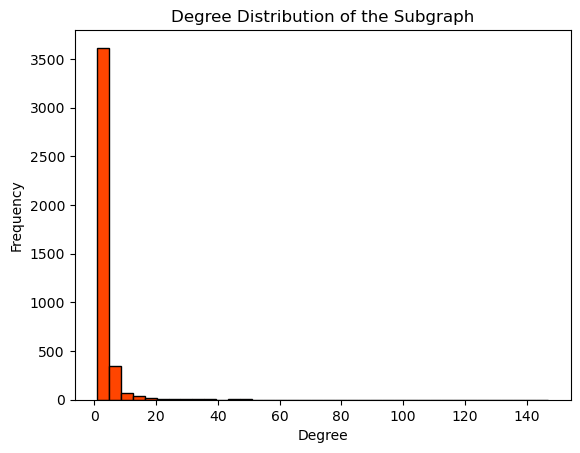

In [24]:
# plot the degree distribution in a histogram
plt.hist(degrees_HC, bins=38, color='orangered', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Subgraph')
plt.savefig("figures/yelp_user_friendship_degree_distribution_subgraph.svg", dpi=300)
plt.show()

Highly skewed degree distribution, with many nodes not having many friends.

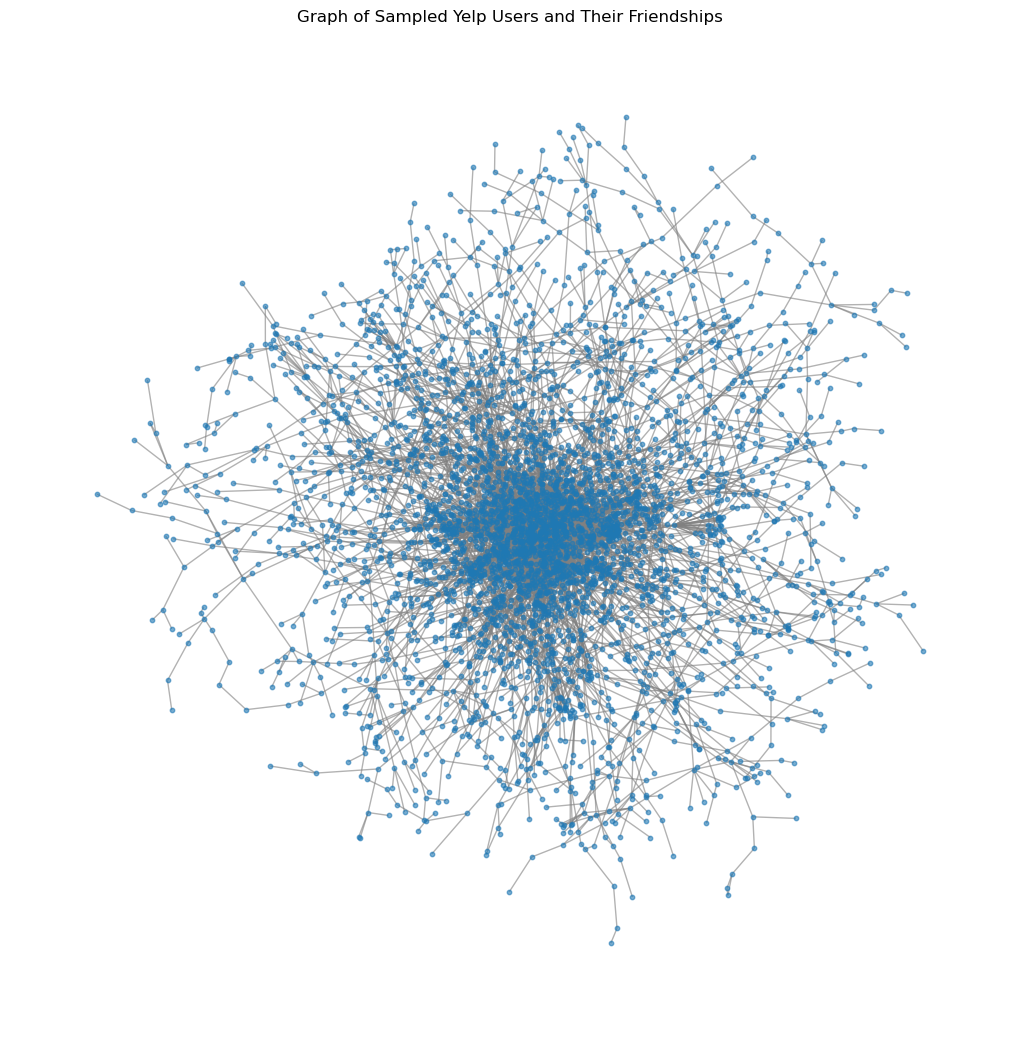

In [25]:
plt.figure(figsize=(10, 10))
nx.draw(H, node_size=10, alpha=0.6, edge_color="gray", with_labels=False)
plt.title("Graph of Sampled Yelp Users and Their Friendships")
plt.savefig("figures/yelp_user_friendship_graph.svg", dpi=300)
plt.show()

In [26]:
graph_dict = nx.to_dict_of_lists(H)

In [27]:
sorted_betweenness = sorted(betweenness_centrality_normalized(graph_dict).items(), key=lambda x: x[1], reverse=True)
print("Top 10 users by betweenness centrality:")
for user, centrality in sorted_betweenness[:10]:
    print(f'User ID: {user}, Betweenness Centrality: {centrality}')

sorted_betweenness = dict(sorted_betweenness)

Top 10 users by betweenness centrality:
User ID: djxnI8Ux8ZYQJhiOQkrRhA, Betweenness Centrality: 0.17624815059183666
User ID: uIjj7EIVBU4kGNgmKPO02A, Betweenness Centrality: 0.14530459988412336
User ID: r3ov7FgibBx41_W74I1KiA, Betweenness Centrality: 0.08741732950571796
User ID: INxvh4Rixsdfzh6PcWc_pw, Betweenness Centrality: 0.07375305092937727
User ID: SRd7-3R8jG_WHAS5C4BfaQ, Betweenness Centrality: 0.06530469808859556
User ID: TL-wgAhbdROaC4b-DA8-7Q, Betweenness Centrality: 0.05423338486642861
User ID: oygdh1nR-FyWsqP7ajoTvw, Betweenness Centrality: 0.053377319146428875
User ID: tJIzUxwfaLDwO6R6wSZ9vw, Betweenness Centrality: 0.05277453588220562
User ID: jt49xjEjQisu6wTTGn6B3A, Betweenness Centrality: 0.05197145358820624
User ID: C6LV0p8L6IfBfh1YFRkWzQ, Betweenness Centrality: 0.05116510717877262


In [28]:
# save to csv to be able to recreate
betweenness_df = pd.DataFrame.from_dict(sorted_betweenness, orient='index', columns=['betweenness_centrality'])
betweenness_df.index.name = 'user_id'
betweenness_df.to_csv('data/processed/yelp_betweenness_centrality.csv')

In [29]:
# Comparing to the built-in function
"""
betweenness_centrality_built_in = nx.betweenness_centrality(H)
sorted_betweenness_built_in = sorted(betweenness_centrality_built_in.items(), key=lambda x: x[1], reverse=True)
print("Top 10 users by betweenness centrality (built-in):")
for user, centrality in sorted_betweenness_built_in[:10]:
    print(f'User ID: {user}, Betweenness Centrality: {centrality}')
"""

'\nbetweenness_centrality_built_in = nx.betweenness_centrality(H)\nsorted_betweenness_built_in = sorted(betweenness_centrality_built_in.items(), key=lambda x: x[1], reverse=True)\nprint("Top 10 users by betweenness centrality (built-in):")\nfor user, centrality in sorted_betweenness_built_in[:10]:\n    print(f\'User ID: {user}, Betweenness Centrality: {centrality}\')\n'

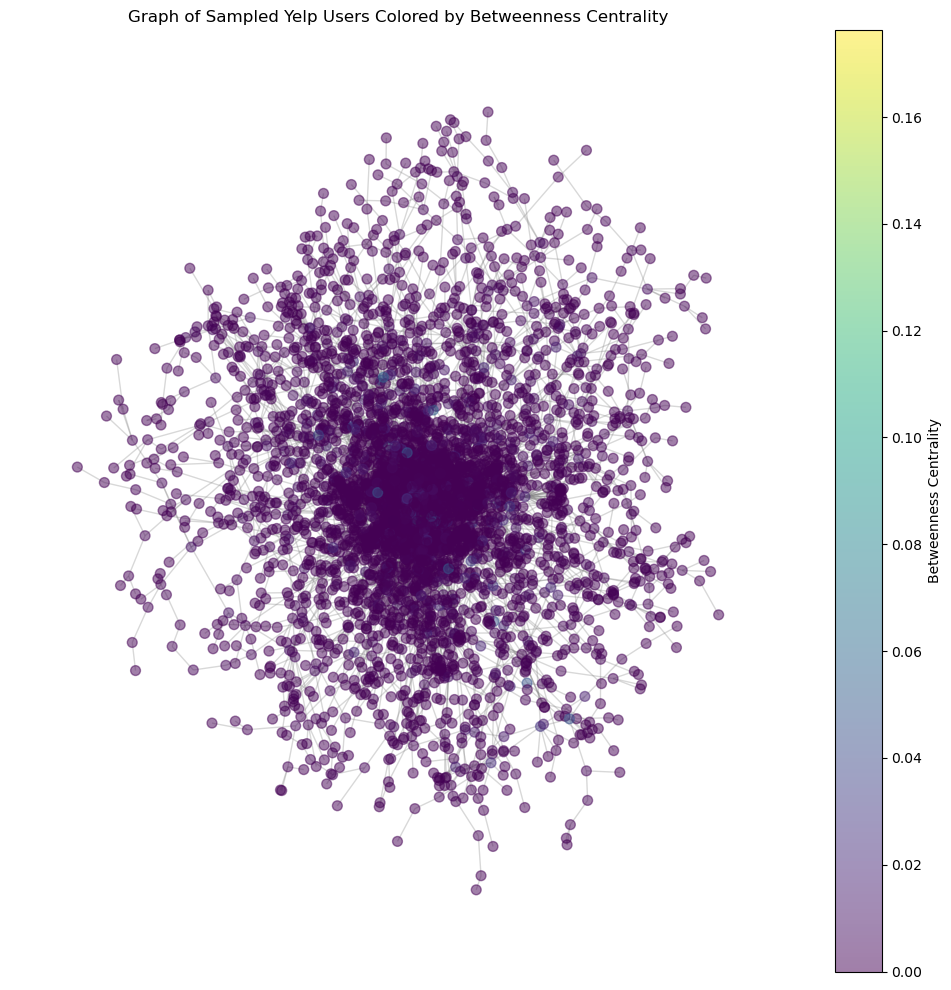

In [30]:
# Change to the manual calculation
node_colors = [sorted_betweenness[n] for n in H.nodes()]

pos = nx.spring_layout(H, seed=SEED)

fig, ax = plt.subplots(figsize=(10, 10))

nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    node_size=50,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.5
)
nx.draw_networkx_edges(H, pos, ax=ax, edge_color="gray", alpha=0.3)

ax.set_title("Graph of Sampled Yelp Users Colored by Betweenness Centrality")
ax.set_axis_off()

cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Betweenness Centrality")

plt.tight_layout()
plt.savefig("figures/yelp_user_friendship_betweenness_centrality.svg", dpi=300)
plt.show()

In [31]:
mods = {}
for k in range(30, 50):
    labels = spectral_clustering(graph_dict, k)
    communities = {}
    for node, lbl in labels.items():
        communities.setdefault(lbl, []).append(node)
    mods[k] = modularity(H, communities.values())

print(mods)
print("Optimal number of clusters (k) based on highest modularity:", max(mods, key=mods.get))

{30: 0.3607353966417314, 31: 0.3503941710082267, 32: 0.36273807401924, 33: 0.3602707225431095, 34: 0.3489458696716387, 35: 0.3704851999565212, 36: 0.3334803390686244, 37: 0.34073443038600637, 38: 0.34718884935343425, 39: 0.37245579830996267, 40: 0.3645986019151011, 41: 0.3729371224210761, 42: 0.3362687999106671, 43: 0.3396220985514794, 44: 0.3948368144763199, 45: 0.40244326168305705, 46: 0.3542258106329144, 47: 0.3509887290792939, 48: 0.39818814286565407, 49: 0.39221647713541197}
Optimal number of clusters (k) based on highest modularity: 45


In [32]:
# pickle the spectral communities
with open('data/processed/yelp_spectral_communities.pkl', 'wb') as f:
    pickle.dump(communities, f)

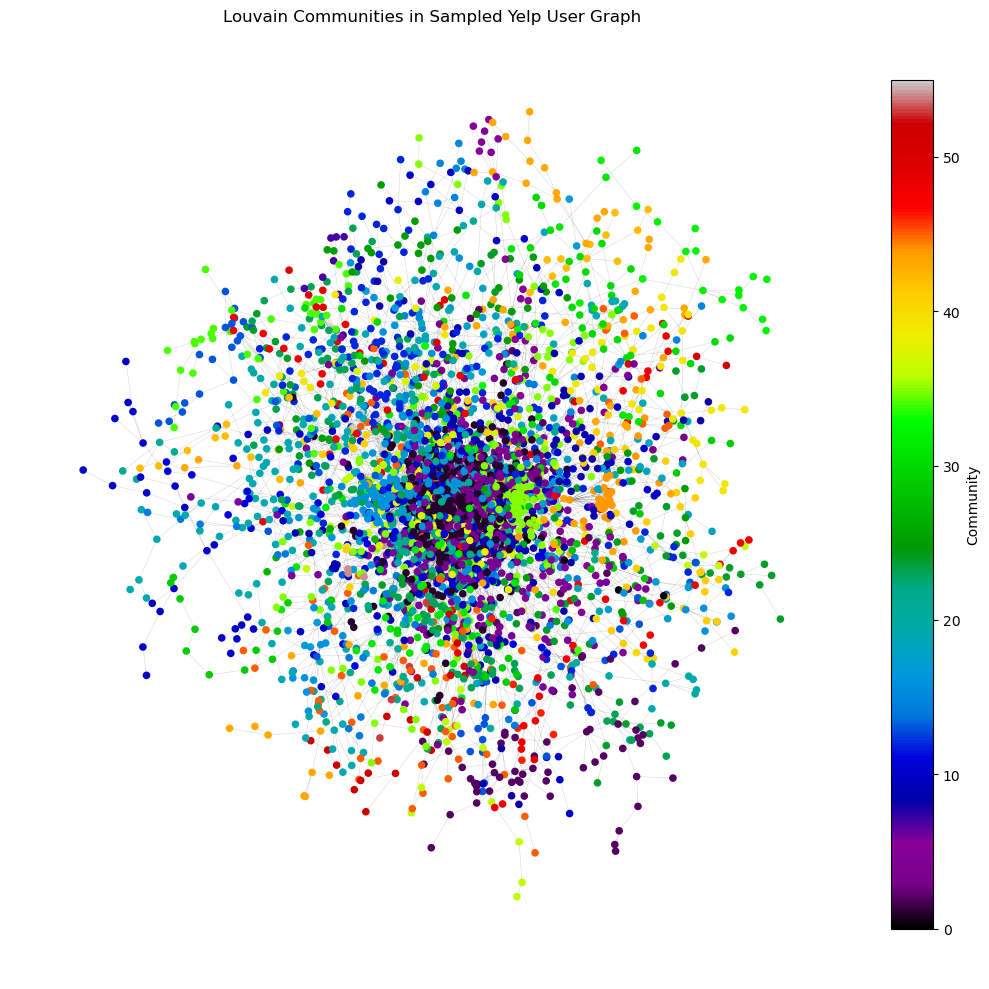

In [33]:
# Louvain partition
partition = community_louvain.best_partition(H, random_state=SEED, randomize=False)

# Map community labels
com_ids = {c: i for i, c in enumerate(sorted(set(partition.values())))}
node_colors = [com_ids[partition[n]] for n in H.nodes()]
num_comms = len(com_ids)

pos = nx.spring_layout(H, seed=SEED)

fig, ax = plt.subplots(figsize=(10, 10))
nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    nodelist=list(H.nodes()),
    node_size=20,
    node_color=node_colors,
    cmap=plt.cm.tab20 if num_comms <= 20 else plt.cm.viridis
)
nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.3, width=0.2)

# Colormap for better distinction between communities
nodes.set_cmap(plt.cm.tab20b if num_comms <= 20 else plt.cm.nipy_spectral)
ax.set_title("Louvain Communities in Sampled Yelp User Graph")
ax.set_axis_off()

cbar = fig.colorbar(nodes, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Community")
if num_comms <= 20:
    cbar.set_ticks(range(num_comms))
    cbar.set_ticklabels(range(num_comms))

plt.tight_layout()
plt.savefig("figures/yelp_user_friendship_louvain_communities.svg", dpi=300)
plt.show()


In [34]:
sizes = pd.Series(list(partition.values())).value_counts()
# number of communities
num_communities = len(sizes)
print(f'Number of communities detected by Louvain method: {num_communities}')
comms = {}
for n,c in partition.items():
    comms.setdefault(c, []).append(n)

modularity_score = modularity(H, comms.values())
print(modularity_score)

Number of communities detected by Louvain method: 56
0.7675436394746156


In [35]:
# pickle the communities
with open('data/processed/yelp_louvain_communities.pkl', 'wb') as f:
    pickle.dump(partition, f)

In [36]:
# user_ids in community 6
users_in_community_6 = [node for node, comm in partition.items() if comm == 6]
print(f'User IDs in community 6: {users_in_community_6}')

User IDs in community 6: ['qypT2VcdYFpuOKZOdDWPRw', 'Bb_kFZkxOxkKxo2B9NzVNQ', 'SRd7-3R8jG_WHAS5C4BfaQ', '3CYDgFXGK5M8qfF8COrXGQ', 'wZXuJrHruRFknsbfcOfzAg', 'MeJsum3QyTO-UGYvsTpESQ', '5NmKO5KXllvcvxRwJNwgVQ', '3KSZIUQjmcwn3IqmZEABdQ', 'foVyn_PKKMvQyHrvum7hPg', 'oxVCNIgYT6qQ-ZKS5nplQg', 'yYyqdT6BlZISmMI611bPwg', 'lz-9qFrEnaQD6xfSW_6ahQ', 'I3cMBZ-Vw7S9RsV-kKAZTA', 'FvhQoDPjajz0L0rNj4br2w', '8Nd-oRuDp_4U5vwd715iCg', '7PpC2AzO4Jw8j29w6dvziQ', 'k-l30gmHhEmTYS1VV--mbA', 'OQ0IDEtTMzbOmlH9YjEYBg', 'uq6HMT9iwnGnhTi7ikCFRw', 'XJRnypFpBstTC69RTTqwwg', 'qgpxgjLEll3kImcUi6GRGA', 'B1ubz7vKWPCt5zi4P2sU7A', '52MmAohG2B0tKt4KCu7L2A', 'ggMuHkapsdaMeBi4iWPvOw', 'qVDZb6yTDTYRH3McxQqvVw', 'F5sU1l2640inrbBL-2ExnQ', 'IZKtoRQ9aMRoeEp4lGJgtg', 'h5Mu3CNxit2RAl7z6_tqLg', 'wxTkCzsphfvZ_QVcwO7Oyg', '3ZTnflnt6K7ZeKAJSbHh1g', 'KQbNJUlzYN70wGgKIl0p_Q', 'eAKdO6sZxQE3f53Sz9dyXA', 'Sh9_bZvNfLB9ZyuvkcWtHQ', 'YG82GCCh0g9P98Wh1hycBg', 'jOfjBuI0zxJ7FFCO-kkwGg', 'gjwYVOucVAOAvciyWwJ4Pw', '7YRPd7hLM-ONzV3ZdGuesg', '_5J6ywlKdQ4

In [37]:
sizes = pd.Series(list(partition.values())).value_counts()
print(sizes)

1     488
3     244
16    243
35    217
12    194
6     185
19    180
8     161
23    152
22    130
24    107
9      97
43     95
10     91
11     90
45     83
31     79
5      78
21     74
2      74
25     72
38     70
18     69
14     67
4      63
48     63
36     59
13     58
30     55
34     53
41     52
39     48
29     45
17     41
15     36
44     33
42     29
52     26
37     21
32     18
20     13
7       8
46      7
40      7
55      6
49      6
28      5
51      5
47      5
54      5
0       5
26      4
33      4
50      4
53      4
27      4
Name: count, dtype: int64


In [38]:
# user_ids in community 6
users_in_community_6 = [node for node, comm in partition.items() if comm == 6]
print(f'User IDs in community 6: {users_in_community_6}')

User IDs in community 6: ['qypT2VcdYFpuOKZOdDWPRw', 'Bb_kFZkxOxkKxo2B9NzVNQ', 'SRd7-3R8jG_WHAS5C4BfaQ', '3CYDgFXGK5M8qfF8COrXGQ', 'wZXuJrHruRFknsbfcOfzAg', 'MeJsum3QyTO-UGYvsTpESQ', '5NmKO5KXllvcvxRwJNwgVQ', '3KSZIUQjmcwn3IqmZEABdQ', 'foVyn_PKKMvQyHrvum7hPg', 'oxVCNIgYT6qQ-ZKS5nplQg', 'yYyqdT6BlZISmMI611bPwg', 'lz-9qFrEnaQD6xfSW_6ahQ', 'I3cMBZ-Vw7S9RsV-kKAZTA', 'FvhQoDPjajz0L0rNj4br2w', '8Nd-oRuDp_4U5vwd715iCg', '7PpC2AzO4Jw8j29w6dvziQ', 'k-l30gmHhEmTYS1VV--mbA', 'OQ0IDEtTMzbOmlH9YjEYBg', 'uq6HMT9iwnGnhTi7ikCFRw', 'XJRnypFpBstTC69RTTqwwg', 'qgpxgjLEll3kImcUi6GRGA', 'B1ubz7vKWPCt5zi4P2sU7A', '52MmAohG2B0tKt4KCu7L2A', 'ggMuHkapsdaMeBi4iWPvOw', 'qVDZb6yTDTYRH3McxQqvVw', 'F5sU1l2640inrbBL-2ExnQ', 'IZKtoRQ9aMRoeEp4lGJgtg', 'h5Mu3CNxit2RAl7z6_tqLg', 'wxTkCzsphfvZ_QVcwO7Oyg', '3ZTnflnt6K7ZeKAJSbHh1g', 'KQbNJUlzYN70wGgKIl0p_Q', 'eAKdO6sZxQE3f53Sz9dyXA', 'Sh9_bZvNfLB9ZyuvkcWtHQ', 'YG82GCCh0g9P98Wh1hycBg', 'jOfjBuI0zxJ7FFCO-kkwGg', 'gjwYVOucVAOAvciyWwJ4Pw', '7YRPd7hLM-ONzV3ZdGuesg', '_5J6ywlKdQ4

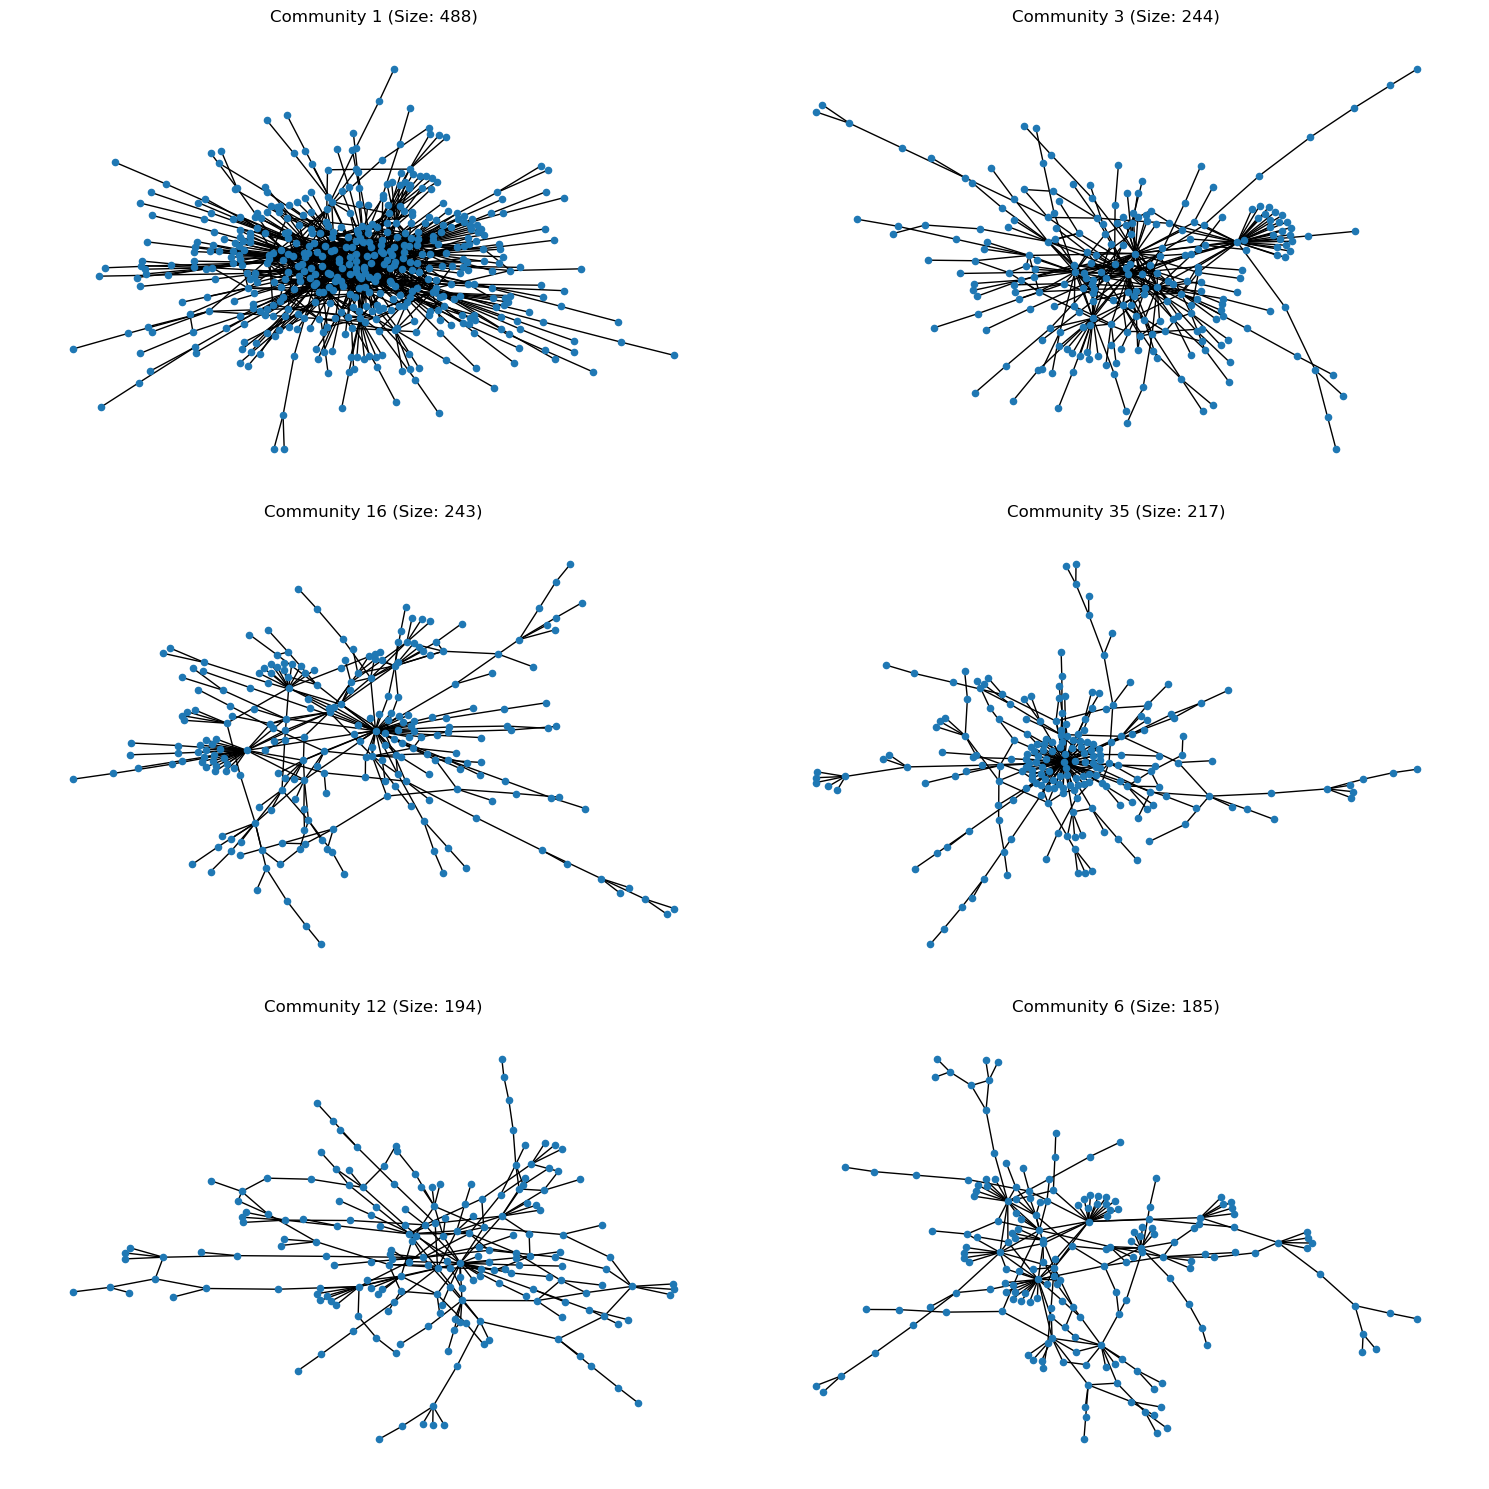

In [39]:
top_6_communities = sizes.index[:6]

plt.figure(figsize=(15, 15))
for i, community in enumerate(top_6_communities, 1):
    nodes = [n for n, c in partition.items() if c == community]
    sub = H.subgraph(nodes)
    plt.subplot(3, 2, i)
    nx.draw(sub, with_labels=False, node_size=20)
    plt.title(f'Community {community} (Size: {sizes[community]})')

plt.tight_layout()
plt.savefig("figures/yelp_user_friendship_top6_communities.svg", dpi=300)
plt.show()


In [40]:
p = Path("data/processed/yelp_louvain_communities.pkl")
print("exists:", p.exists())
print("size:", p.stat().st_size if p.exists() else None)


exists: True
size: 111597


In [41]:
user_community_df = pd.DataFrame(
    [(node, comm) for node, comm in partition.items()],
    columns=["user_id", "community"]
)

# save as csv
user_community_df.to_csv(DATA_DIR_PROC / "yelp_user_communities.csv", index=False)

# Apriori on the communities 

In [ ]:
# size of the communities
sizes = pd.Series(list(partition.values())).value_counts()

# Top 3 largest communities
top_3_communities = sizes.index[:3].tolist()
print(f"Top 3 communities (by size): {top_3_communities}")
print(f"Sizes: {sizes[top_3_communities].tolist()}")

# Middle 3 communities
middle_index_start = len(sizes) // 2 - 1
middle_3_communities = sizes.index[middle_index_start:middle_index_start +3].tolist()
print(f"\nMiddle 3 communities (by size): {middle_3_communities}")
print(f"Sizes: {sizes[middle_3_communities].tolist()}")

Top 3 communities (by size): [1, 3, 16]
Sizes: [488, 244, 243]

Middle 3 communities (by size): [13, 30, 34]
Sizes: [58, 55, 53]


In [45]:

# Create a mapping: user_id -> community_id
user_to_community = partition  # This is already user_id -> community_id

# Get user sets for each community
top_3_users = {
    comm: set([user for user, c in partition.items() if c == comm])
    for comm in top_3_communities
}

bottom_3_users = {
    comm: set([user for user, c in partition.items() if c == comm])
    for comm in middle_3_communities
}

print(f"\nTop 3 user counts: {[len(top_3_users[c]) for c in top_3_communities]}")
print(f"Bottom 3 user counts: {[len(bottom_3_users[c]) for c in middle_3_communities]}")


Top 3 user counts: [488, 244, 243]
Bottom 3 user counts: [58, 55, 53]


In [47]:
def filter_baskets_by_community(baskets_df, user_ids_set):
    """Filter baskets to only include users in the given set"""
    filtered = baskets_df[baskets_df['user_id'].isin(user_ids_set)].copy()
    return filtered

# Load original baskets
liked_baskets = pd.read_parquet("data/processed/baskets_liked_ids.parquet")
hated_baskets = pd.read_parquet("data/processed/baskets_hated_ids.parquet")

# Filter for each community
communities_to_analyze = {
    **{f"top_{i+1}": (comm, top_3_users[comm]) for i, comm in enumerate(top_3_communities)},
    **{f"bottom_{i+1}": (comm, bottom_3_users[comm]) for i, comm in enumerate(middle_3_communities)}
}

filtered_data = {}
for name, (comm_id, user_set) in communities_to_analyze.items():
    filtered_data[name] = {
        'community_id': comm_id,
        'liked': filter_baskets_by_community(liked_baskets, user_set),
        'hated': filter_baskets_by_community(hated_baskets, user_set)
    }
    print(f"{name} (comm {comm_id}): {len(filtered_data[name]['liked'])} liked baskets, {len(filtered_data[name]['hated'])} hated baskets")

top_1 (comm 1): 196 liked baskets, 96 hated baskets
top_2 (comm 3): 81 liked baskets, 45 hated baskets
top_3 (comm 16): 106 liked baskets, 55 hated baskets
bottom_1 (comm 13): 13 liked baskets, 8 hated baskets
bottom_2 (comm 30): 8 liked baskets, 5 hated baskets
bottom_3 (comm 34): 20 liked baskets, 9 hated baskets


In [64]:
import src.apriori as apriori
from pathlib import Path

# Your existing functions
def baskets_df_to_transactions(df):
    """Convert dataframe to transaction list"""
    return [set(items) for items in df["items"]]

def decode_itemset(itemset):
    """Convert set/tuple of IDs to sorted tuple of category names"""
    if isinstance(itemset, (frozenset, set)):
        itemset = sorted(itemset)
    return tuple(id2cat_map.get(x, f"<ID_{x}>") for x in itemset)

# Parameters
min_support = 0.13
min_conf = 0.5

# Create output directory for community results
output_dir = Path("data/processed/apriori_results/communities")
output_dir.mkdir(parents=True, exist_ok=True)

# Run Apriori for each community
results_summary = []

for name, data in filtered_data.items():
    comm_id = data['community_id']
    print(f"\n{'='*60}")
    print(f"Processing {name} (Community {comm_id})")
    print(f"{'='*60}")
    
    # Convert to transactions
    liked_tx = baskets_df_to_transactions(data['liked'])
    hated_tx = baskets_df_to_transactions(data['hated'])
    
    print(f"Liked transactions: {len(liked_tx)}")
    print(f"Hated transactions: {len(hated_tx)}")
    
    # === LIKED ===
    if len(liked_tx) > 0:
        print(f"\nApplying Apriori on LIKED...")
        frequent_liked, support_map_liked = apriori.apriori_triangular(liked_tx, min_support)
        rules_liked = apriori.generate_rules(frequent_liked, liked_tx, min_conf)
        print(f"Generated {len(rules_liked)} liked rules")
        
        if rules_liked:
            df_rules_liked = pd.DataFrame(rules_liked).sort_values("Lift", ascending=False)
            df_rules_liked["Antecedent_decoded"] = df_rules_liked["Antecedent"].apply(decode_itemset)
            df_rules_liked["Consequent_decoded"] = df_rules_liked["Consequent"].apply(decode_itemset)
            
            # Save
            df_rules_liked.to_parquet(output_dir / f"rules_liked_{name}_comm{comm_id}.parquet", index=False)
            df_rules_liked[["Antecedent_decoded", "Consequent_decoded", 
                           "Support", "Confidence", "Lift"]].to_csv(
                output_dir / f"rules_liked_{name}_comm{comm_id}_human.csv", index=False
            )
        else:
            print("⚠️ No liked rules generated")
            df_rules_liked = pd.DataFrame()
    else:
        print("⚠️ No liked transactions")
        df_rules_liked = pd.DataFrame()
    
    # === HATED ===
    if len(hated_tx) > 0:
        print(f"\nApplying Apriori on HATED...")
        frequent_hated, support_map_hated = apriori.apriori_triangular(hated_tx, min_support)
        rules_hated = apriori.generate_rules(frequent_hated, hated_tx, min_conf)
        print(f"Generated {len(rules_hated)} hated rules")
        
        if rules_hated:
            df_rules_hated = pd.DataFrame(rules_hated).sort_values("Lift", ascending=False)
            df_rules_hated["Antecedent_decoded"] = df_rules_hated["Antecedent"].apply(decode_itemset)
            df_rules_hated["Consequent_decoded"] = df_rules_hated["Consequent"].apply(decode_itemset)
            
            # Save
            df_rules_hated.to_parquet(output_dir / f"rules_hated_{name}_comm{comm_id}.parquet", index=False)
            df_rules_hated[["Antecedent_decoded", "Consequent_decoded", 
                           "Support", "Confidence", "Lift"]].to_csv(
                output_dir / f"rules_hated_{name}_comm{comm_id}_human.csv", index=False
            )
        else:
            print("⚠️ No hated rules generated")
            df_rules_hated = pd.DataFrame()
    else:
        print("⚠️ No hated transactions")
        df_rules_hated = pd.DataFrame()
    
    # Store summary
    results_summary.append({
        'name': name,
        'community_id': comm_id,
        'n_users': len(communities_to_analyze[name][1]),
        'n_liked_baskets': len(liked_tx),
        'n_hated_baskets': len(hated_tx),
        'n_liked_rules': len(rules_liked) if 'rules_liked' in locals() else 0,
        'n_hated_rules': len(rules_hated) if 'rules_hated' in locals() else 0
    })

# Print summary
print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
summary_df = pd.DataFrame(results_summary)
print(summary_df)
summary_df.to_csv(output_dir / "community_apriori_summary.csv", index=False)


Processing top_1 (Community 1)
Liked transactions: 196
Hated transactions: 96

Applying Apriori on LIKED...
Generated 7 liked rules

Applying Apriori on HATED...
Generated 13 hated rules

Processing top_2 (Community 3)
Liked transactions: 81
Hated transactions: 45

Applying Apriori on LIKED...
Generated 3 liked rules

Applying Apriori on HATED...
Generated 4 hated rules

Processing top_3 (Community 16)
Liked transactions: 106
Hated transactions: 55

Applying Apriori on LIKED...
Generated 118 liked rules

Applying Apriori on HATED...
Generated 16 hated rules

Processing bottom_1 (Community 13)
Liked transactions: 13
Hated transactions: 8

Applying Apriori on LIKED...
Generated 2495 liked rules

Applying Apriori on HATED...
Generated 180 hated rules

Processing bottom_2 (Community 30)
Liked transactions: 8
Hated transactions: 5

Applying Apriori on LIKED...
Generated 4 liked rules

Applying Apriori on HATED...
Generated 106 hated rules

Processing bottom_3 (Community 34)
Liked transacti

In [66]:
# Load and compare results
def load_community_rules(name, comm_id, rule_type='liked'):
    """Load rules for a specific community"""
    path = output_dir / f"rules_{rule_type}_{name}_comm{comm_id}.parquet"
    if path.exists():
        return pd.read_parquet(path)
    return pd.DataFrame()

# Example: Compare top 3 communities
print("\n=== TOP 5 LIKED RULES BY COMMUNITY ===")
for name in ['top_1', 'top_2', 'top_3']:
    comm_id = filtered_data[name]['community_id']
    rules = load_community_rules(name, comm_id, 'liked')
    if not rules.empty:
        print(f"\n{name} (Community {comm_id}):")
        print(rules[['Antecedent_decoded', 'Consequent_decoded', 'Lift']].head(5))
        
        
print("\n=== TOP 5 HATED RULES BY COMMUNITY ===")
for name in ['bottom_1', 'bottom_2', 'bottom_3']:
    comm_id = filtered_data[name]['community_id']
    rules = load_community_rules(name, comm_id, 'hated')
    if not rules.empty:
        print(f"\n{name} (Community {comm_id}):")
        print(rules[['Antecedent_decoded', 'Consequent_decoded', 'Lift']].head(5))


=== TOP 5 LIKED RULES BY COMMUNITY ===

top_1 (Community 1):
  Antecedent_decoded        Consequent_decoded      Lift
0       [Sandwiches]      [Breakfast & Brunch]  1.793464
1     [Coffee & Tea]      [Breakfast & Brunch]  1.793464
2       [Sandwiches]  [American (Traditional)]  1.621324
3     [Coffee & Tea]          [American (New)]  1.609963
4       [Sandwiches]          [American (New)]  1.609963

top_2 (Community 3):
         Antecedent_decoded        Consequent_decoded      Lift
0              [Sandwiches]  [American (Traditional)]  1.674812
1  [American (Traditional)]          [American (New)]  1.356027
2                 [Seafood]          [American (New)]  1.265625

top_3 (Community 16):
                       Antecedent_decoded  \
0    [American (Traditional), Sandwiches]   
1      [Breakfast & Brunch, Cajun/Creole]   
2        [Breakfast & Brunch, Sandwiches]   
3  [American (Traditional), Cajun/Creole]   
4    [American (Traditional), Sandwiches]   

                       C

# Sentiment Analysis 